In [1]:
import os, glob, time, datetime
import numpy as np
from PIL import Image
import imageio
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import torch.nn as nn
from torchvision.utils import save_image

from common.dataset import TrainDataProvider, save_fixed_sample
from common.function import init_embedding
from common.models import Encoder, Decoder, Discriminator, Generator
from common.utils import denorm_image
from common.utils import centering_image
from common.train import Trainer

## Freeze : Encoder만 얼린다

## Transfer Learning
- 150epoch 가 pre-trained 된 모델을 이용해서 손글씨를 적은 데이터로 학습시킨다

In [3]:
GPU = torch.cuda.is_available()
GPU

True

### Save Fixed sample

In [4]:
# sample_size = 24
# img_size = 128
# fontid = 0
# data_dir = './handwritings/50font_dataset_210chars/'
# save_dir = './handwritings/fixed_fake_210chars_1/'

# save_fixed_sample(sample_size, img_size, fontid, data_dir, save_dir)

In [10]:
data_dir = './handwritings/50font_dataset_210chars/'
model_dir = './model_checkpoint_210chars/old_freeze'
fixed_dir = './handwritings/fixed_fake_210chars/old_freeze'
fixed_id = 0
fonts_num = 25
batch_size = 10
img_size = 128

In [7]:
trainer = Trainer(GPU, data_dir, fixed_dir, fonts_num, batch_size, img_size)

unpickled total 217 examples
unpickled total 2133 examples
train examples -> 217, val examples -> 2133
total batches: 22


### Ground Truth Target

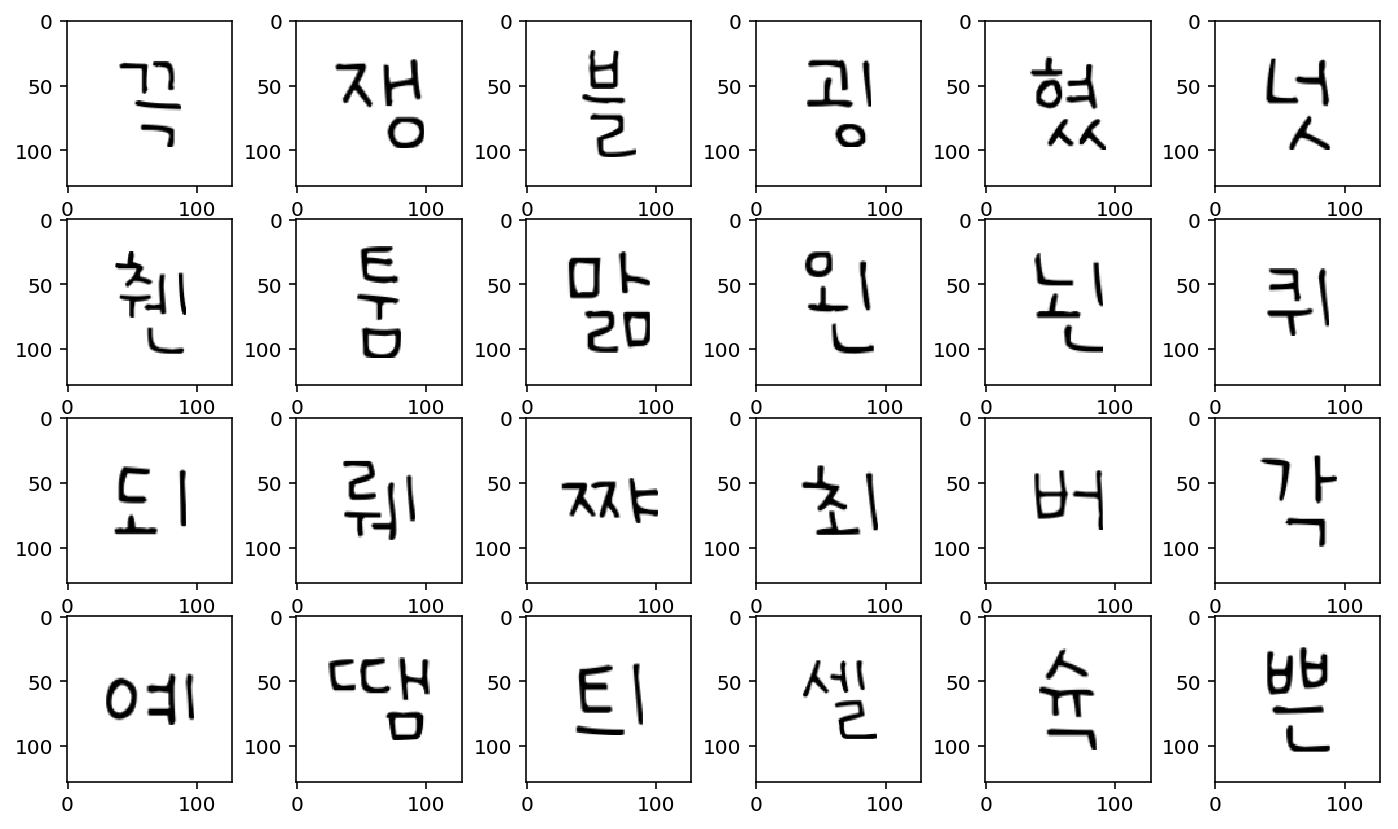

In [9]:
fixed_target = torch.load(os.path.join(fixed_dir, 'fixed_target.pkl'))

plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_target):
    plt.subplot(4, 6, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().numpy(), cmap='gray')
plt.show()

In [18]:
save_image(denorm_image(fixed_target.data), \
           os.path.join(fixed_dir, '0_Ground_truth_target_210chars.png'), \
           nrow=6, pad_value=255)

---

### freeze_encoder=True 로 두고 Transfer Learning!
- loss가 안 튀는 곳까지만 학습시키기

In [34]:
save_path = './handwritings/fixed_fake_210chars/'
to_model_path = './handwritings/model_checkpoint_210chars/'
from_model_path = './model_checkpoint/'
restore = ['150-0604-10:42-Encoder.pkl', '150-0604-10:42-Decoder.pkl', '150-0604-10:42-Discriminator.pkl']

max_epoch = 5
schedule = 10
lr = 0.0005
log_step = 20
sample_step = 20

losses = trainer.train(max_epoch=max_epoch, schedule=schedule, save_path=save_path, \
                       lr=lr, log_step=log_step, sample_step=sample_step, restore=restore, \
                       to_model_path=to_model_path, from_model_path=from_model_path, \
                       with_charid=True, freeze_encoder=True, save_nrow=6)

150 epoch trained model has restored
12:23:47 Epoch [151/155], step [20/21], l1_loss: 22.2794, d_loss: 0.0086, g_loss: 40.7355
12:23:50 Epoch [152/155], step [20/21], l1_loss: 18.0662, d_loss: 0.0002, g_loss: 29.3313
12:23:53 Epoch [153/155], step [20/21], l1_loss: 17.7800, d_loss: 0.0711, g_loss: 21.0440
12:23:56 Epoch [154/155], step [20/21], l1_loss: 15.4674, d_loss: 0.0024, g_loss: 22.1577
12:23:59 Epoch [155/155], step [20/21], l1_loss: 14.4808, d_loss: 0.0048, g_loss: 21.4865


### losses

In [35]:
l1_losses, const_losses, category_losses, d_losses, g_losses = losses

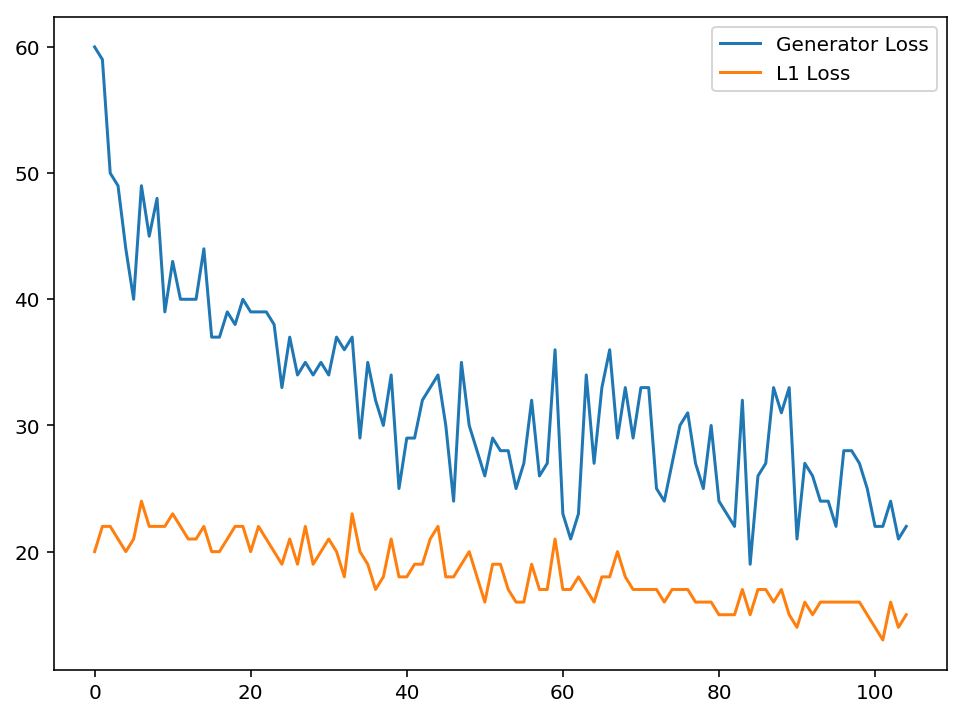

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(g_losses, label='Generator Loss')
plt.plot(l1_losses, label='L1 Loss')
plt.legend()
plt.show()

### Fine Tune - 156~300epoch

In [37]:
save_path = './handwritings/fixed_fake_210chars/'
to_model_path = './handwritings/model_checkpoint_210chars/'
from_model_path = './handwritings/model_checkpoint_210chars/'
restore = ['155-0609-12:24-Encoder.pkl', '155-0609-12:24-Decoder.pkl', '155-0609-12:24-Discriminator.pkl']

max_epoch = 145
schedule = 40
lr = 0.001
log_step = 20
sample_step = 20

losses = trainer.train(max_epoch=max_epoch, schedule=schedule, save_path=save_path, \
                       lr=lr, log_step=log_step, sample_step=sample_step, restore=restore, \
                       to_model_path=to_model_path, from_model_path=from_model_path, \
                       with_charid=True, freeze_encoder=True, fine_tune=True, \
                       save_nrow=6, model_save_step=30)

155 epoch trained model has restored
12:25:10 Epoch [156/300], step [20/21], l1_loss: 68.7456, d_loss: 0.0002, g_loss: 80.2649
12:25:13 Epoch [157/300], step [20/21], l1_loss: 59.2531, d_loss: 0.0008, g_loss: 67.5604
12:25:16 Epoch [158/300], step [20/21], l1_loss: 51.5980, d_loss: 0.0000, g_loss: 65.9932
12:25:19 Epoch [159/300], step [20/21], l1_loss: 49.5203, d_loss: 0.0136, g_loss: 61.8507
12:25:22 Epoch [160/300], step [20/21], l1_loss: 48.0665, d_loss: 0.0087, g_loss: 63.1710
12:25:25 Epoch [161/300], step [20/21], l1_loss: 58.9951, d_loss: 0.0005, g_loss: 67.7789
12:25:28 Epoch [162/300], step [20/21], l1_loss: 59.6241, d_loss: 0.0002, g_loss: 73.9359
12:25:31 Epoch [163/300], step [20/21], l1_loss: 48.6326, d_loss: 0.0011, g_loss: 56.2549
12:25:34 Epoch [164/300], step [20/21], l1_loss: 60.2250, d_loss: 0.0001, g_loss: 70.5420
12:25:37 Epoch [165/300], step [20/21], l1_loss: 55.4431, d_loss: 0.0001, g_loss: 65.6479
12:25:40 Epoch [166/300], step [20/21], l1_loss: 55.1185, d_los

12:29:39 Epoch [246/300], step [20/21], l1_loss: 51.0815, d_loss: 0.0096, g_loss: 61.5334
12:29:42 Epoch [247/300], step [20/21], l1_loss: 42.8594, d_loss: 0.0295, g_loss: 51.4056
12:29:45 Epoch [248/300], step [20/21], l1_loss: 54.1108, d_loss: 0.0090, g_loss: 60.6129
12:29:48 Epoch [249/300], step [20/21], l1_loss: 46.4488, d_loss: 0.0113, g_loss: 56.6675
12:29:51 Epoch [250/300], step [20/21], l1_loss: 49.9539, d_loss: 0.0118, g_loss: 55.2791
12:29:54 Epoch [251/300], step [20/21], l1_loss: 49.4727, d_loss: 0.0035, g_loss: 56.4420
12:29:57 Epoch [252/300], step [20/21], l1_loss: 62.3966, d_loss: 0.0033, g_loss: 70.2595
12:30:00 Epoch [253/300], step [20/21], l1_loss: 48.9082, d_loss: 0.1462, g_loss: 57.1506
12:30:03 Epoch [254/300], step [20/21], l1_loss: 51.3279, d_loss: 0.0188, g_loss: 56.4384
12:30:06 Epoch [255/300], step [20/21], l1_loss: 45.2996, d_loss: 0.0096, g_loss: 52.6736
12:30:09 Epoch [256/300], step [20/21], l1_loss: 47.5457, d_loss: 0.0055, g_loss: 54.9148
12:30:12 E

- 1epoch에 3초 : 100epoch에 300초, 5분

In [38]:
l1_losses, const_losses, category_losses, d_losses, g_losses = losses

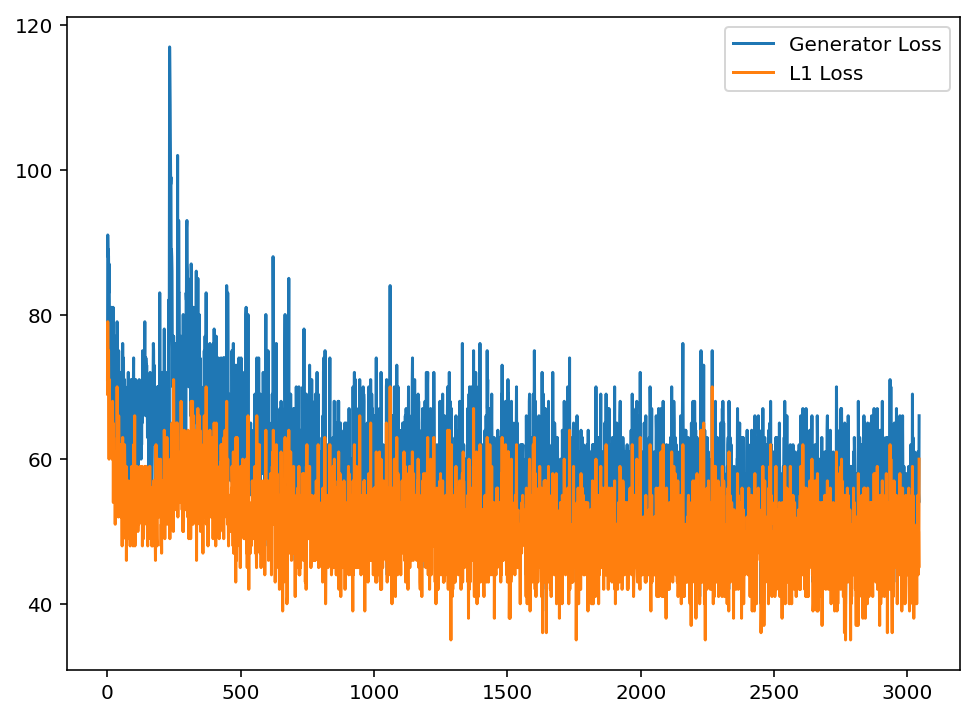

In [39]:
plt.figure(figsize=(8, 6))
plt.plot(g_losses, label='Generator Loss')
plt.plot(l1_losses, label='L1 Loss')
plt.legend()
plt.show()

In [43]:
print('initial loss:', np.mean(g_losses[:500]), '->', 'last loss:', np.mean(g_losses[-500:]))

initial loss: 68.954 -> last loss: 55.194


### 300~500 epoch train
- 100epoch에 5분, 200epoch에 10분

In [9]:
save_path = './handwritings/fixed_fake_210chars/'
to_model_path = './handwritings/model_checkpoint_210chars/'
from_model_path = './handwritings/model_checkpoint_210chars/'
restore = ['300-0609-12:32-Encoder.pkl', '300-0609-12:32-Decoder.pkl', '300-0609-12:32-Discriminator.pkl']

max_epoch = 200
schedule = 40
lr = 0.0002
log_step = 20
sample_step = 20

losses = trainer.train(max_epoch=max_epoch, schedule=schedule, save_path=save_path, \
                       lr=lr, log_step=log_step, sample_step=sample_step, restore=restore, \
                       to_model_path=to_model_path, from_model_path=from_model_path, \
                       with_charid=True, freeze_encoder=True, fine_tune=True, \
                       save_nrow=6, model_save_step=30, flip_labels=True)

300 epoch trained model has restored
13:59:06 Epoch [301/500], step [20/21], l1_loss: 41.6149, d_loss: 0.0024, g_loss: 50.8158
13:59:09 Epoch [302/500], step [20/21], l1_loss: 44.9271, d_loss: 0.0136, g_loss: 53.7141
13:59:12 Epoch [303/500], step [20/21], l1_loss: 36.6448, d_loss: 0.0203, g_loss: 42.7063
13:59:15 Epoch [304/500], step [20/21], l1_loss: 45.0410, d_loss: 0.1140, g_loss: 47.5273
13:59:18 Epoch [305/500], step [20/21], l1_loss: 53.3515, d_loss: 0.0026, g_loss: 61.7317
13:59:21 Epoch [306/500], step [20/21], l1_loss: 41.6856, d_loss: 0.1686, g_loss: 50.8763
13:59:24 Epoch [307/500], step [20/21], l1_loss: 51.1410, d_loss: 0.0012, g_loss: 59.9875
13:59:27 Epoch [308/500], step [20/21], l1_loss: 37.6880, d_loss: 0.0032, g_loss: 48.0371
13:59:30 Epoch [309/500], step [20/21], l1_loss: 45.6005, d_loss: 0.0799, g_loss: 58.7954
13:59:33 Epoch [310/500], step [20/21], l1_loss: 38.6389, d_loss: 1.0859, g_loss: 51.9455
13:59:36 Epoch [311/500], step [20/21], l1_loss: 43.9350, d_los

14:03:39 Epoch [392/500], step [20/21], l1_loss: 54.8444, d_loss: 0.0079, g_loss: 60.6761
14:03:42 Epoch [393/500], step [20/21], l1_loss: 43.7226, d_loss: 0.0061, g_loss: 52.6951
14:03:45 Epoch [394/500], step [20/21], l1_loss: 46.8786, d_loss: 0.4232, g_loss: 48.9413
14:03:48 Epoch [395/500], step [20/21], l1_loss: 39.9049, d_loss: 0.0049, g_loss: 47.8140
14:03:51 Epoch [396/500], step [20/21], l1_loss: 52.4155, d_loss: 0.1205, g_loss: 55.3886
14:03:54 Epoch [397/500], step [20/21], l1_loss: 44.9625, d_loss: 0.0483, g_loss: 50.3215
14:03:57 Epoch [398/500], step [20/21], l1_loss: 38.5737, d_loss: 0.0458, g_loss: 42.6878
14:04:00 Epoch [399/500], step [20/21], l1_loss: 45.0530, d_loss: 0.0640, g_loss: 52.4128
14:04:03 Epoch [400/500], step [20/21], l1_loss: 42.8379, d_loss: 0.0586, g_loss: 46.5000
14:04:06 Epoch [401/500], step [20/21], l1_loss: 39.2064, d_loss: 0.0088, g_loss: 46.3445
14:04:09 Epoch [402/500], step [20/21], l1_loss: 39.9070, d_loss: 0.3693, g_loss: 48.7935
14:04:12 E

14:08:14 Epoch [484/500], step [20/21], l1_loss: 47.1963, d_loss: 0.1200, g_loss: 49.9262
14:08:17 Epoch [485/500], step [20/21], l1_loss: 45.4067, d_loss: 0.0406, g_loss: 50.7355
14:08:20 Epoch [486/500], step [20/21], l1_loss: 45.6890, d_loss: 0.0070, g_loss: 52.5882
14:08:23 Epoch [487/500], step [20/21], l1_loss: 39.8606, d_loss: 0.0330, g_loss: 45.5470
14:08:26 Epoch [488/500], step [20/21], l1_loss: 43.0643, d_loss: 0.1060, g_loss: 46.2080
14:08:29 Epoch [489/500], step [20/21], l1_loss: 45.5414, d_loss: 0.0014, g_loss: 54.5271
14:08:32 Epoch [490/500], step [20/21], l1_loss: 39.0415, d_loss: 0.3552, g_loss: 40.9592
14:08:35 Epoch [491/500], step [20/21], l1_loss: 39.0040, d_loss: 0.0219, g_loss: 44.0277
14:08:38 Epoch [492/500], step [20/21], l1_loss: 52.5796, d_loss: 0.0022, g_loss: 59.5821
14:08:41 Epoch [493/500], step [20/21], l1_loss: 38.9188, d_loss: 0.0190, g_loss: 43.5929
14:08:44 Epoch [494/500], step [20/21], l1_loss: 42.5539, d_loss: 0.0017, g_loss: 50.1314
14:08:47 E

In [10]:
l1_losses, const_losses, category_losses, d_losses, g_losses = losses

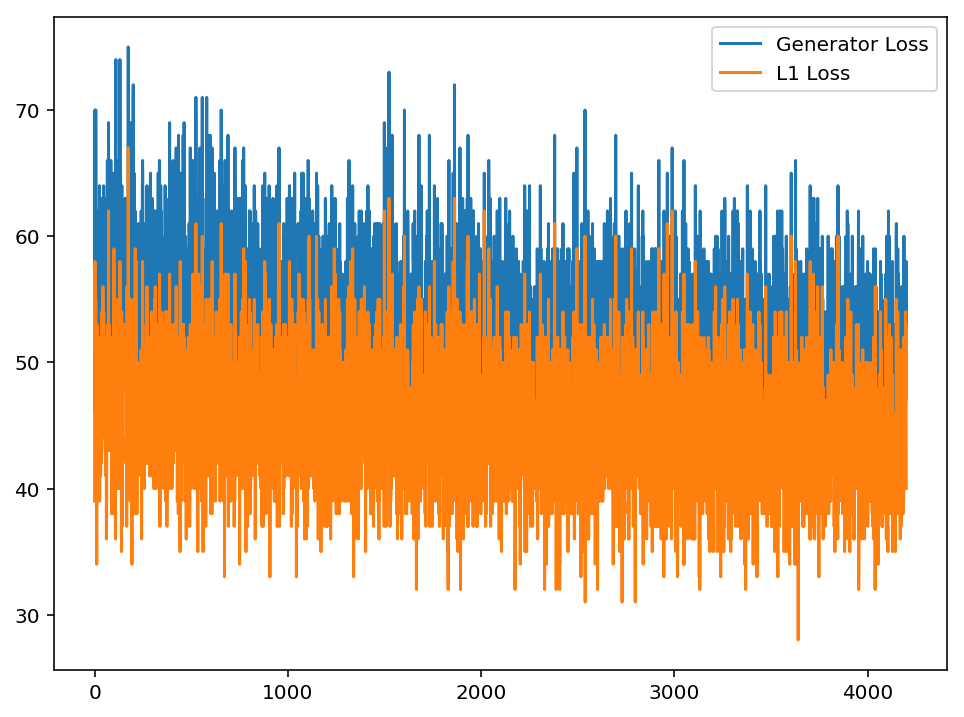

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(g_losses, label='Generator Loss')
plt.plot(l1_losses, label='L1 Loss')
plt.legend()
plt.show()

In [12]:
print('initial loss:', np.mean(g_losses[:500]), '->', 'last loss:', np.mean(g_losses[-500:]))

initial loss: 55.53 -> last loss: 50.562


- 계속 loss가 내려가네.. 더 학습시켜야겠는데

### 500~1000 epoch

In [84]:
save_path = './handwritings/fixed_fake_210chars/'
to_model_path = './handwritings/model_checkpoint_210chars/'
from_model_path = './handwritings/model_checkpoint_210chars/'
restore = ['500-0609-14:09-Encoder.pkl', '500-0609-14:09-Decoder.pkl', '500-0609-14:09-Discriminator.pkl']

max_epoch = 500
schedule = 40
lr = 0.0002
log_step = 20
sample_step = 20

losses = trainer.train(max_epoch=max_epoch, schedule=schedule, save_path=save_path, \
                       lr=lr, log_step=log_step, sample_step=sample_step, restore=restore, \
                       to_model_path=to_model_path, from_model_path=from_model_path, \
                       with_charid=True, freeze_encoder=True, fine_tune=True, \
                       save_nrow=6, model_save_step=30, flip_labels=True)

500 epoch trained model has restored
14:40:34 Epoch [501/1000], step [20/21], l1_loss: 36.6670, d_loss: 0.0087, g_loss: 45.3259
14:40:37 Epoch [502/1000], step [20/21], l1_loss: 43.6706, d_loss: 0.0079, g_loss: 52.9630
14:40:40 Epoch [503/1000], step [20/21], l1_loss: 35.9065, d_loss: 0.0146, g_loss: 41.9568
14:40:43 Epoch [504/1000], step [20/21], l1_loss: 42.1722, d_loss: 1.2688, g_loss: 43.2372
14:40:46 Epoch [505/1000], step [20/21], l1_loss: 34.2697, d_loss: 0.0271, g_loss: 40.8125
14:40:49 Epoch [506/1000], step [20/21], l1_loss: 48.0336, d_loss: 0.0146, g_loss: 53.4794
14:40:52 Epoch [507/1000], step [20/21], l1_loss: 44.7568, d_loss: 0.1030, g_loss: 48.6694
14:40:55 Epoch [508/1000], step [20/21], l1_loss: 38.4917, d_loss: 0.0126, g_loss: 44.6226
14:40:58 Epoch [509/1000], step [20/21], l1_loss: 44.2657, d_loss: 0.0089, g_loss: 58.7917
14:41:01 Epoch [510/1000], step [20/21], l1_loss: 37.8614, d_loss: 0.0692, g_loss: 47.2286
14:41:04 Epoch [511/1000], step [20/21], l1_loss: 54.

14:45:05 Epoch [591/1000], step [20/21], l1_loss: 42.1012, d_loss: 0.0019, g_loss: 50.9752
14:45:08 Epoch [592/1000], step [20/21], l1_loss: 43.4190, d_loss: 0.0229, g_loss: 49.1478
14:45:11 Epoch [593/1000], step [20/21], l1_loss: 41.5471, d_loss: 0.0126, g_loss: 47.6168
14:45:14 Epoch [594/1000], step [20/21], l1_loss: 35.1347, d_loss: 0.2472, g_loss: 37.3659
14:45:17 Epoch [595/1000], step [20/21], l1_loss: 37.1185, d_loss: 0.0057, g_loss: 44.6466
14:45:20 Epoch [596/1000], step [20/21], l1_loss: 40.3391, d_loss: 0.0680, g_loss: 51.1333
14:45:23 Epoch [597/1000], step [20/21], l1_loss: 44.4365, d_loss: 0.0478, g_loss: 49.2380
14:45:26 Epoch [598/1000], step [20/21], l1_loss: 36.9235, d_loss: 0.0125, g_loss: 45.8643
14:45:29 Epoch [599/1000], step [20/21], l1_loss: 48.0018, d_loss: 0.0025, g_loss: 54.9876
14:45:32 Epoch [600/1000], step [20/21], l1_loss: 36.9155, d_loss: 0.1156, g_loss: 42.2632
14:45:35 Epoch [601/1000], step [20/21], l1_loss: 42.9896, d_loss: 0.0311, g_loss: 48.2854

14:49:38 Epoch [682/1000], step [20/21], l1_loss: 40.2422, d_loss: 0.1906, g_loss: 44.0052
14:49:41 Epoch [683/1000], step [20/21], l1_loss: 37.3096, d_loss: 0.0194, g_loss: 43.2311
14:49:44 Epoch [684/1000], step [20/21], l1_loss: 47.5900, d_loss: 0.0236, g_loss: 52.9324
14:49:48 Epoch [685/1000], step [20/21], l1_loss: 39.4379, d_loss: 0.0019, g_loss: 48.5963
14:49:50 Epoch [686/1000], step [20/21], l1_loss: 36.7235, d_loss: 0.1223, g_loss: 40.6262
14:49:53 Epoch [687/1000], step [20/21], l1_loss: 39.8848, d_loss: 0.0327, g_loss: 45.1954
14:49:56 Epoch [688/1000], step [20/21], l1_loss: 40.4788, d_loss: 0.0318, g_loss: 45.9753
14:49:59 Epoch [689/1000], step [20/21], l1_loss: 43.2029, d_loss: 0.0051, g_loss: 50.1945
14:50:02 Epoch [690/1000], step [20/21], l1_loss: 44.1034, d_loss: 0.0380, g_loss: 49.2340
14:50:05 Epoch [691/1000], step [20/21], l1_loss: 38.2960, d_loss: 0.2171, g_loss: 48.5328
14:50:08 Epoch [692/1000], step [20/21], l1_loss: 44.9940, d_loss: 0.0088, g_loss: 51.4815

14:54:12 Epoch [773/1000], step [20/21], l1_loss: 37.3932, d_loss: 0.0662, g_loss: 41.1821
14:54:15 Epoch [774/1000], step [20/21], l1_loss: 40.4589, d_loss: 0.0634, g_loss: 47.5865
14:54:18 Epoch [775/1000], step [20/21], l1_loss: 40.5819, d_loss: 0.0940, g_loss: 48.0597
14:54:21 Epoch [776/1000], step [20/21], l1_loss: 44.6949, d_loss: 0.0128, g_loss: 50.6344
14:54:24 Epoch [777/1000], step [20/21], l1_loss: 36.9326, d_loss: 0.0030, g_loss: 44.3420
14:54:27 Epoch [778/1000], step [20/21], l1_loss: 40.2415, d_loss: 0.0244, g_loss: 45.1544
14:54:30 Epoch [779/1000], step [20/21], l1_loss: 34.7971, d_loss: 0.0433, g_loss: 40.7292
14:54:33 Epoch [780/1000], step [20/21], l1_loss: 46.2947, d_loss: 0.0035, g_loss: 53.7575
14:54:36 Epoch [781/1000], step [20/21], l1_loss: 42.3496, d_loss: 0.2745, g_loss: 48.4632
14:54:39 Epoch [782/1000], step [20/21], l1_loss: 48.1396, d_loss: 0.0075, g_loss: 57.3412
14:54:42 Epoch [783/1000], step [20/21], l1_loss: 35.3723, d_loss: 0.2170, g_loss: 37.4485

14:58:46 Epoch [864/1000], step [20/21], l1_loss: 43.3178, d_loss: 0.0310, g_loss: 50.3698
14:58:49 Epoch [865/1000], step [20/21], l1_loss: 47.7807, d_loss: 0.0135, g_loss: 53.4974
14:58:52 Epoch [866/1000], step [20/21], l1_loss: 41.9017, d_loss: 0.6755, g_loss: 42.9105
14:58:55 Epoch [867/1000], step [20/21], l1_loss: 39.2115, d_loss: 0.0621, g_loss: 45.5603
14:58:58 Epoch [868/1000], step [20/21], l1_loss: 36.5423, d_loss: 0.0344, g_loss: 41.9080
14:59:01 Epoch [869/1000], step [20/21], l1_loss: 31.2854, d_loss: 0.0041, g_loss: 39.2049
14:59:04 Epoch [870/1000], step [20/21], l1_loss: 43.7365, d_loss: 0.0033, g_loss: 52.2190
14:59:07 Epoch [871/1000], step [20/21], l1_loss: 41.4814, d_loss: 0.0112, g_loss: 48.3390
14:59:10 Epoch [872/1000], step [20/21], l1_loss: 50.5764, d_loss: 0.0330, g_loss: 55.1963
14:59:13 Epoch [873/1000], step [20/21], l1_loss: 41.5316, d_loss: 0.0070, g_loss: 48.4328
14:59:16 Epoch [874/1000], step [20/21], l1_loss: 39.3572, d_loss: 0.0008, g_loss: 49.8950

15:03:19 Epoch [955/1000], step [20/21], l1_loss: 50.2232, d_loss: 0.0021, g_loss: 59.3810
15:03:22 Epoch [956/1000], step [20/21], l1_loss: 45.8113, d_loss: 0.0077, g_loss: 53.7675
15:03:25 Epoch [957/1000], step [20/21], l1_loss: 34.8552, d_loss: 0.0040, g_loss: 44.1548
15:03:28 Epoch [958/1000], step [20/21], l1_loss: 42.9480, d_loss: 0.0889, g_loss: 46.7522
15:03:31 Epoch [959/1000], step [20/21], l1_loss: 43.1612, d_loss: 0.0787, g_loss: 49.9062
15:03:34 Epoch [960/1000], step [20/21], l1_loss: 43.1894, d_loss: 0.0224, g_loss: 49.5449
15:03:37 Epoch [961/1000], step [20/21], l1_loss: 42.2434, d_loss: 0.0097, g_loss: 50.0872
15:03:40 Epoch [962/1000], step [20/21], l1_loss: 51.3748, d_loss: 0.0017, g_loss: 63.7254
15:03:43 Epoch [963/1000], step [20/21], l1_loss: 42.7933, d_loss: 0.0612, g_loss: 47.5923
15:03:46 Epoch [964/1000], step [20/21], l1_loss: 40.8899, d_loss: 0.1936, g_loss: 44.4908
15:03:49 Epoch [965/1000], step [20/21], l1_loss: 29.4840, d_loss: 0.0156, g_loss: 34.6262

In [85]:
l1_losses, const_losses, category_losses, d_losses, g_losses = losses

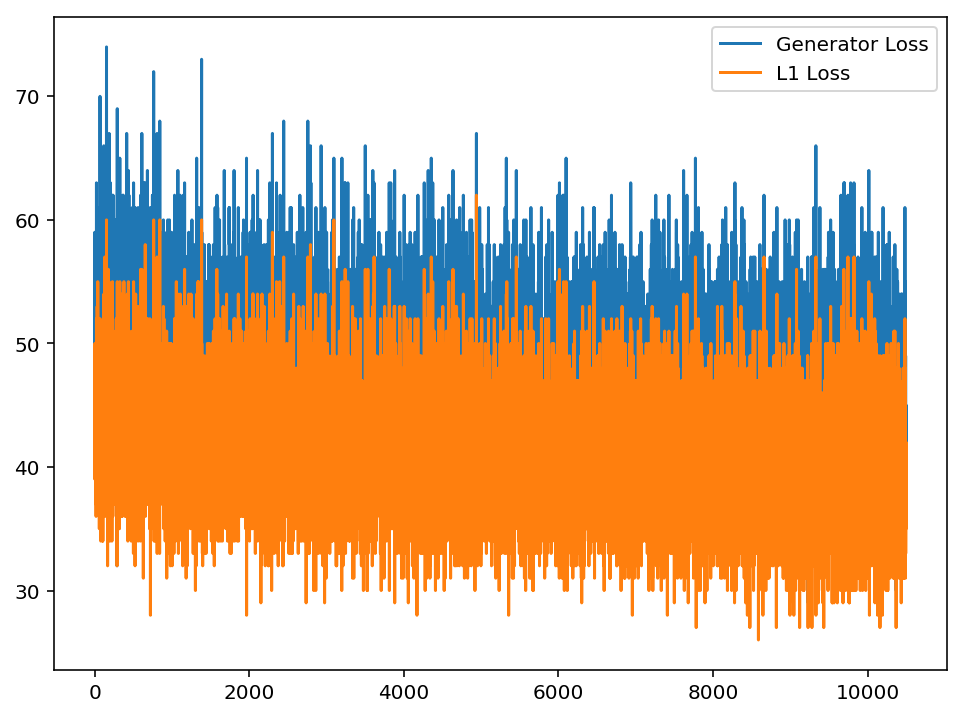

In [86]:
plt.figure(figsize=(8, 6))
plt.plot(g_losses, label='Generator Loss')
plt.plot(l1_losses, label='L1 Loss')
plt.legend()
plt.show()

In [87]:
print('initial loss:', np.mean(g_losses[:500]), '->', 'last loss:', np.mean(g_losses[-500:]))

initial loss: 52.0 -> last loss: 45.362


- WOW

---

### save GIF

In [38]:
image_path = './handwritings/fixed_fake_210chars/'
filenames = sorted(glob.glob(os.path.join(image_path, "*.png")))[1:]
filenames = filenames[:20] + [filenames[idx] for idx in range(21, len(filenames)-200) if ((idx+1) % 5) == 0]
print(len(filenames))
filenames[-10:]

46


['./handwritings/fixed_fake_210chars/fake_samples-255-20.png',
 './handwritings/fixed_fake_210chars/fake_samples-260-20.png',
 './handwritings/fixed_fake_210chars/fake_samples-265-20.png',
 './handwritings/fixed_fake_210chars/fake_samples-270-20.png',
 './handwritings/fixed_fake_210chars/fake_samples-275-20.png',
 './handwritings/fixed_fake_210chars/fake_samples-280-20.png',
 './handwritings/fixed_fake_210chars/fake_samples-285-20.png',
 './handwritings/fixed_fake_210chars/fake_samples-290-20.png',
 './handwritings/fixed_fake_210chars/fake_samples-295-20.png',
 './handwritings/fixed_fake_210chars/fake_samples-300-20.png']

In [39]:
gif_path = './handwritings/gifz'
image_path = './handwritings/fixed_fake_210chars/'
file_name = 'handwriting_test_training.gif'

images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave(os.path.join(gif_path, file_name), images)

---

# Validation
- 안 본 글자들도 생성해보기

### Model import

In [88]:
from_model_path = './handwritings/model_checkpoint_210chars/'
fixed_dir = './handwritings/fixed_sample/'

In [89]:
embeddings = torch.load(os.path.join(fixed_dir, 'EMBEDDINGS.pkl'))
embeddings.shape

torch.Size([100, 1, 1, 128])

In [90]:
En = Encoder().cuda()
De = Decoder().cuda()
D = Discriminator(category_num=25).cuda()

restore = ['1000-0609-15:05-Encoder.pkl', '1000-0609-15:05-Decoder.pkl', '1000-0609-15:05-Discriminator.pkl']

encoder_path, decoder_path, discriminator_path = restore
prev_epoch = int(encoder_path.split('-')[0])
En.load_state_dict(torch.load(os.path.join(from_model_path, encoder_path)))
De.load_state_dict(torch.load(os.path.join(from_model_path, decoder_path)))
D.load_state_dict(torch.load(os.path.join(from_model_path, discriminator_path)))
print("%d epoch trained model has restored" % prev_epoch)

1000 epoch trained model has restored


### data import (Val data)

In [91]:
batch_size = 24
data_dir = './handwritings/50font_dataset_210chars/'
data_provider = TrainDataProvider(data_dir)
val_batch_iter = data_provider.get_val_iter(batch_size, with_charid=True)   

unpickled total 210 examples
unpickled total 2140 examples
train examples -> 210, val examples -> 2140


### show

In [92]:
for i, batch in enumerate(val_batch_iter):
    font_ids, char_ids, batch_images = batch
    batch_images = batch_images.cuda()
    
    # target / source images
    real_target = batch_images[:, 0, :, :]
    real_target = real_target.view([batch_size, 1, img_size, img_size])
    real_source = batch_images[:, 1, :, :]
    real_source = real_source.view([batch_size, 1, img_size, img_size])

    # centering
    for idx, (image_S, image_T) in enumerate(zip(real_source, real_target)):
        image_S = image_S.cpu().detach().numpy().reshape(img_size, img_size)
        image_S = centering_image(image_S, resize_fix=90)
        real_source[idx] = torch.tensor(image_S).view([1, img_size, img_size])
        image_T = image_T.cpu().detach().numpy().reshape(img_size, img_size)
        image_T = centering_image(image_T)
        real_target[idx] = torch.tensor(image_T).view([1, img_size, img_size])
        
    fake_target, encoded_source, _ = Generator(real_source, En, De, embeddings, \
                                               font_ids, GPU=GPU, encode_layers=True)
    break

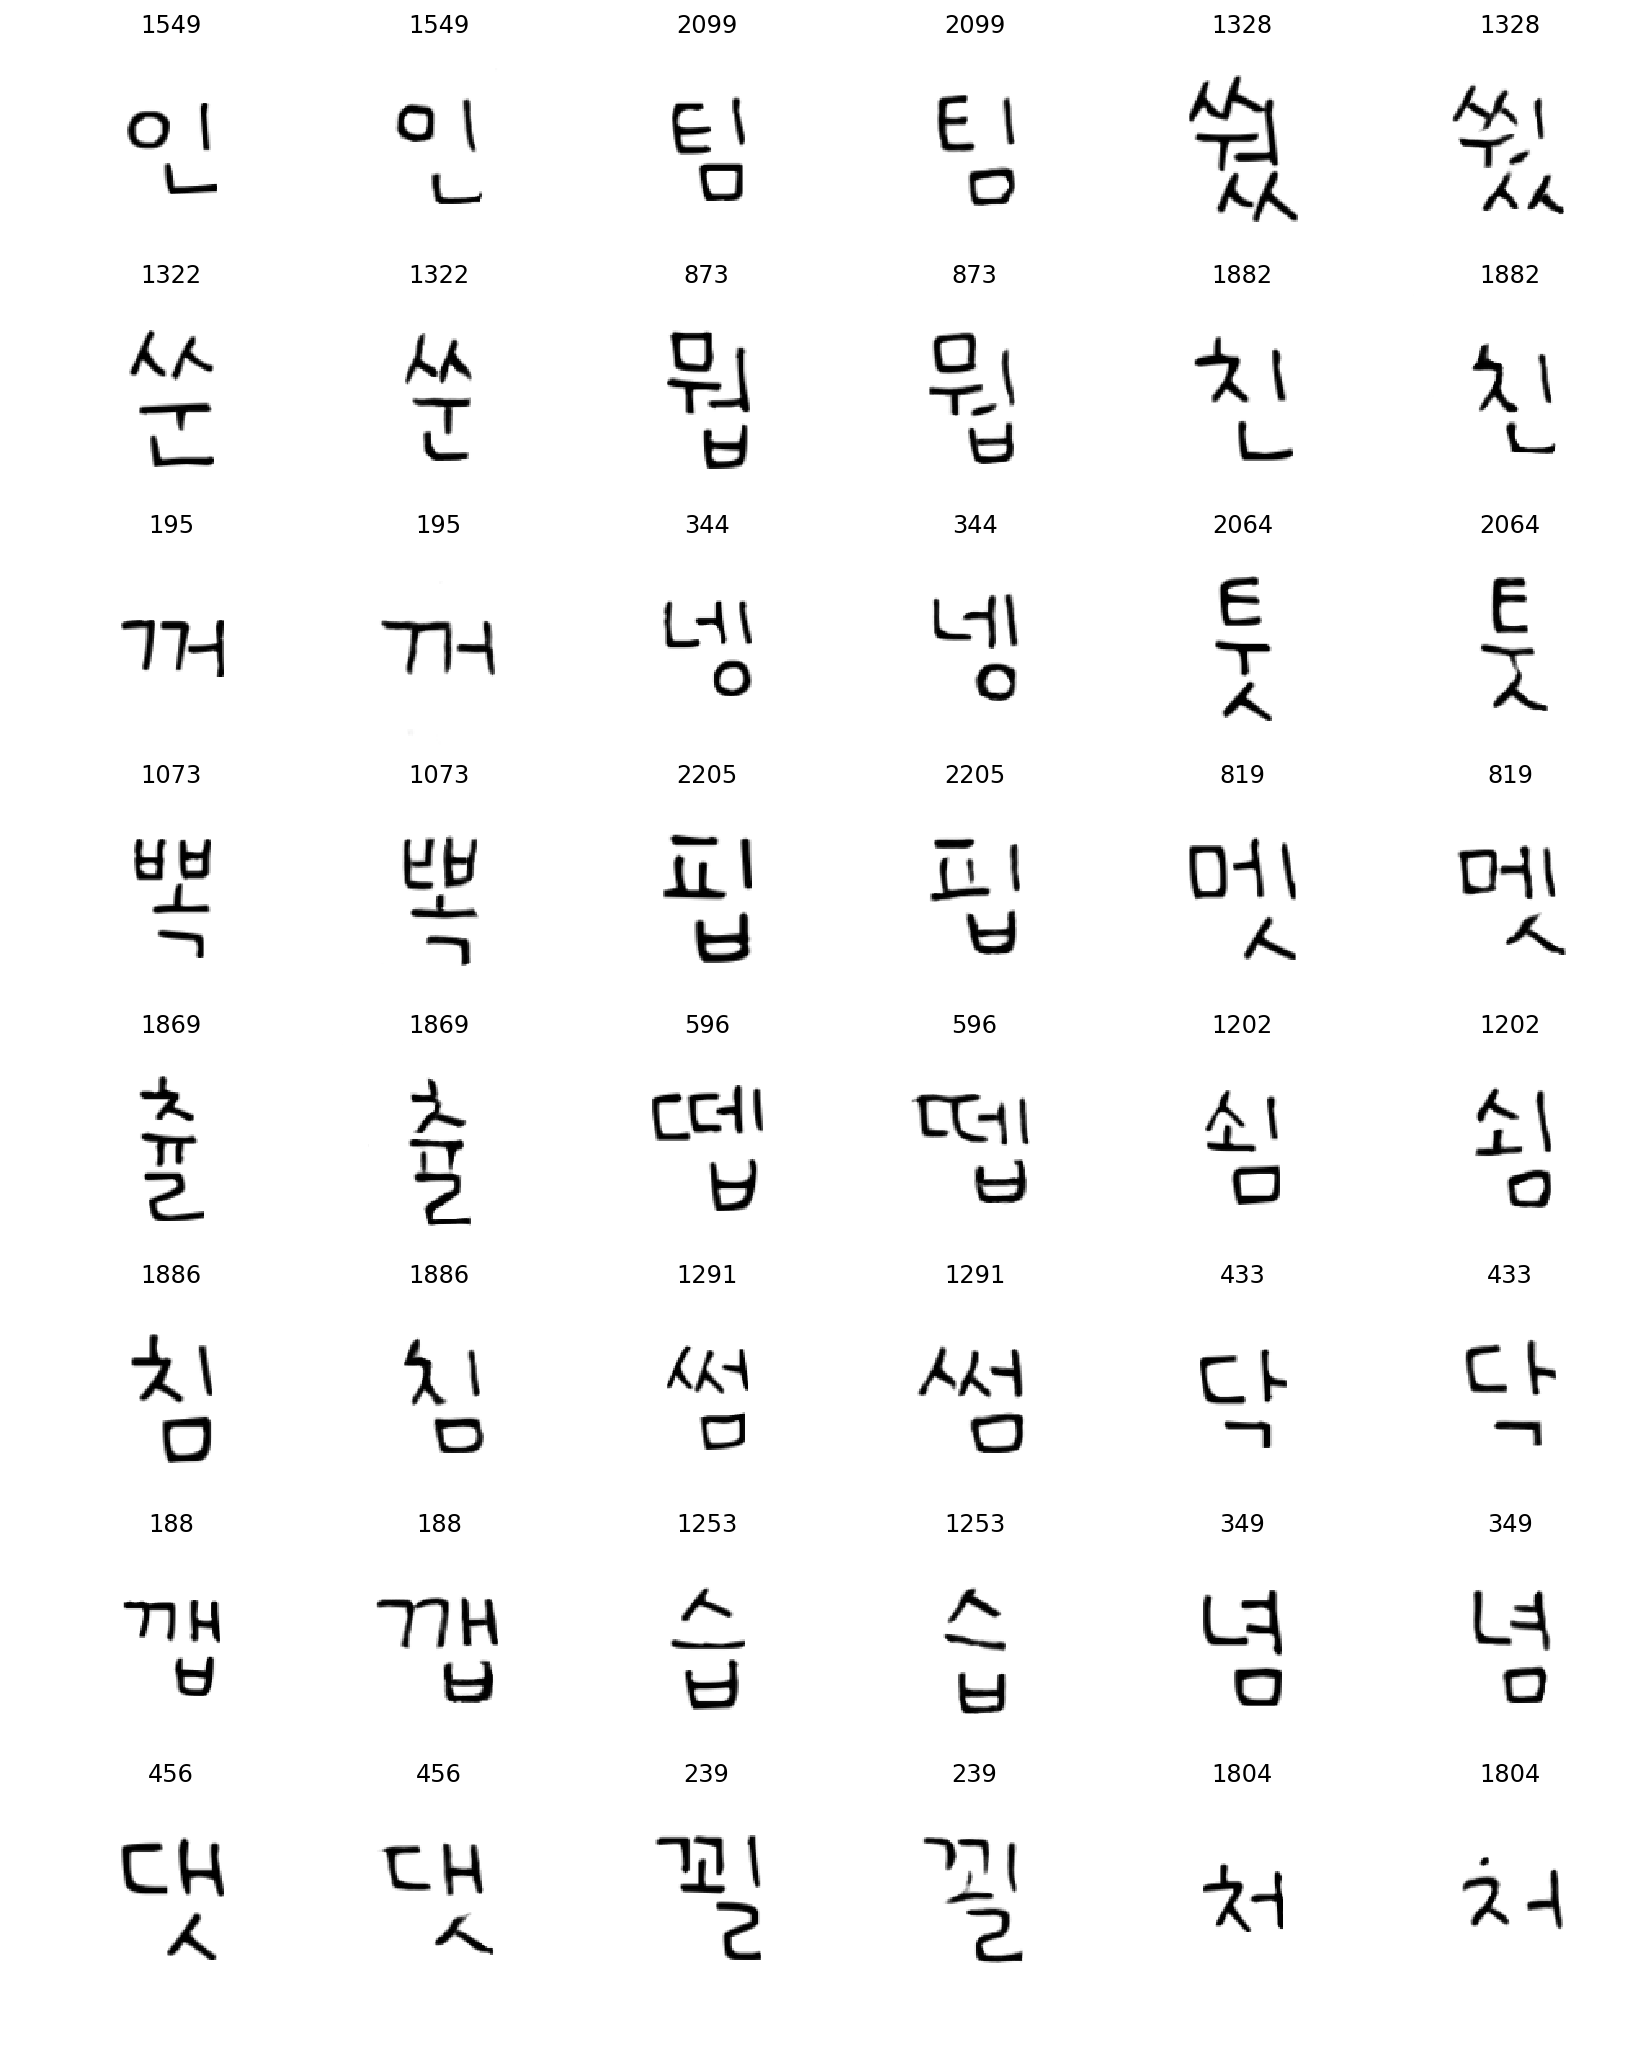

In [93]:
plt.figure(figsize=(14, 18))
for idx, (image_R, image_F) in enumerate(zip(real_target, fake_target)):
    plt.subplot(8, 6, 2*idx+1)
    plt.imshow(image_R.cpu().detach().numpy().reshape(128, 128), cmap='gray')
    plt.title(char_ids[idx])
    plt.axis('off')
    
    plt.subplot(8, 6, 2*idx+2)
    plt.imshow(image_F.cpu().detach().numpy().reshape(128, 128), cmap='gray')
    plt.title(char_ids[idx])
    plt.axis('off')
plt.show()

- OMG......


- 잘써.......